In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm_notebook
import datetime
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

## 讀取BBC. UDN. HK01

In [2]:
hk = pd.read_csv("Data_class/香港01.csv")
udn = pd.read_csv("Data_class/UDN.csv")
bbc = pd.read_csv("Data_class/BBC.csv")

In [3]:
print(bbc["日期"][0])
print(udn["日期"][0])
print(hk["日期"][0])

2019-11-27 15:20:47
2019-11-30
2019-03-31


In [4]:
def to_date1(each_row):
    b = datetime.datetime.strptime(each_row, "%Y-%m-%d %H:%M:%S")
    return b
def to_date2(each_row):
    c = datetime.datetime.strptime(each_row, "%Y-%m-%d")
    return c

bbc["日期"] = bbc["日期"].apply(to_date1, 1)
udn["日期"] = udn["日期"].apply(to_date2, 1)
hk["日期"] = hk["日期"].apply(to_date2, 1)

## Jieba斷詞(有自建辭典)

In [5]:
import jieba
jieba.load_userdict("dict2.txt")

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/9t/t_r18jtx2t17njq7cpc2q1d80000gn/T/jieba.cache
Loading model cost 1.064 seconds.
Prefix dict has been built succesfully.


In [6]:
def parsing_jieba(row):
    stop_list = [line[:-1] for line in open("stop_words.txt")]
    sentence = ""
    words = []
    for k in jieba.cut(row, cut_all = False):
        if k not in stop_list and k  != ' ':
            sentence = sentence + " " + k
            words.append(k)
    return sentence, words
jieba_segment1, jieba_segment2 = [], []
for i in tqdm_notebook(range(len(hk))):
    s, w = parsing_jieba(hk["內容"][i])
    jieba_segment1.append(s)
    jieba_segment2.append(w)
jieba_segment3, jieba_segment4 = [], []
for i in tqdm_notebook(range(len(udn))):
    s, w = parsing_jieba(udn["內容"][i])
    jieba_segment3.append(s)
    jieba_segment4.append(w)
jieba_segment5, jieba_segment6 = [], []
for i in tqdm_notebook(range(len(bbc))):
    s, w = parsing_jieba(bbc["內容"][i])
    jieba_segment5.append(s)
    jieba_segment6.append(w)

In [7]:
hk['jieba_sentence'], hk['jieba_list'] = jieba_segment1, jieba_segment2
udn['jieba_sentence'], udn['jieba_list'] = jieba_segment3, jieba_segment4
bbc['jieba_sentence'], bbc['jieba_list'] = jieba_segment5, jieba_segment6

In [8]:
def train_test(df):
    train = df[df['立場'].isna() != True].reset_index(drop=True)
    test = df[df['立場'].isna() == True].reset_index(drop=True)
    return train, test
hk_train, hk_test = train_test(hk)
udn_train, udn_test = train_test(udn)
bbc_train, bbc_test = train_test(bbc)

## 畫圖

In [11]:
hk_train['新聞媒體'] = "香港01"
udn_train['新聞媒體'] = "UDN"
bbc_train['新聞媒體'] = "BBC中文"
all_train =  pd.concat([hk_train, udn_train, bbc_train], axis = 0)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [12]:
all_train.groupby(["新聞媒體","立場"]).count()

Url  jieba_list  jieba_sentence   內容   搜尋   日期   標籤   標題
新聞媒體  立場                                                           
BBC中文 0.0   42          42              42   42   42   42   42   42
      1.0  117         117             117  117  117  117  117  117
      2.0   78          78              78   78   78   78   78   78
UDN   0.0  480         480             480  480  480  480  480  480
      1.0  596         596             596  596  596  596  596  596
      2.0  683         683             683  683  683  683  683  683
香港01  0.0  193         193             193  193  193  193  193  193
      1.0  405         405             405  405  405  405  405  405
      2.0  235         235             235  235  235  235  235  235

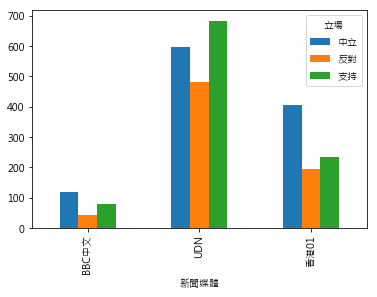

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame([['反對','香港01',193],['中立','香港01',405],['支持','香港01',235],['反對','UDN',480],
                   ['中立','UDN',596],['支持','UDN',683], ['反對','BBC中文',42],
                   ['中立','BBC中文',117],['支持','BBC中文',78]],columns=['立場','新聞媒體','個數'])

fig = df.pivot("新聞媒體", "立場", "個數").plot(kind='bar')
fig.figure.savefig("all.png")
plt.show()

## Token

In [14]:
import keras
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

In [15]:
corpus_hk = hk_train['jieba_sentence']
corpus_udn = udn_train['jieba_sentence']
corpus_bbc = bbc_train['jieba_sentence']
corpus = pd.concat([corpus_hk, corpus_udn, corpus_bbc], axis = 0)
corpus = corpus.reset_index(drop = True)
corpus.shape

(2829,)

In [16]:
tokenizer.fit_on_texts(corpus)

In [17]:
hk_train_corpus = tokenizer.texts_to_sequences(corpus_hk)
udn_train_corpus = tokenizer.texts_to_sequences(corpus_udn)
bbc_train_corpus = tokenizer.texts_to_sequences(corpus_bbc)

## 將Token轉成一樣長的

In [14]:
hk_max_seq_len = max([len(seq) for seq in hk_train_corpus])
udn_max_seq_len = max([len(seq) for seq in udn_train_corpus])
bbc_max_seq_len = max([len(seq) for seq in bbc_train_corpus])
print(hk_max_seq_len)
print(udn_max_seq_len)
print(bbc_max_seq_len)

3200
1243
1544


In [15]:
MAX_SEQUENCE_LENGTH = 500
hk_train_corpus = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(hk_train_corpus, 
                   maxlen=MAX_SEQUENCE_LENGTH)

udn_train_corpus = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(udn_train_corpus, 
                   maxlen=MAX_SEQUENCE_LENGTH)

bbc_train_corpus = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(bbc_train_corpus, 
                   maxlen=MAX_SEQUENCE_LENGTH)

In [16]:
corpus_hk_test = hk_test['jieba_sentence']
corpus_udn_test = udn_test['jieba_sentence']
corpus_bbc_test = bbc_test['jieba_sentence']
corpus_test = pd.concat([corpus_hk_test, corpus_udn_test, corpus_bbc_test], axis = 0)
corpus_test = corpus_test.reset_index(drop = True)
corpus_test.shape
tokenizer.fit_on_texts(corpus_test)
hk_test_corpus = tokenizer.texts_to_sequences(corpus_hk_test)
udn_test_corpus = tokenizer.texts_to_sequences(corpus_udn_test)
bbc_test_corpus = tokenizer.texts_to_sequences(corpus_bbc_test)
hk_max_seq_test_len = max([len(seq) for seq in hk_test_corpus])
udn_max_seq_test_len = max([len(seq) for seq in udn_test_corpus])
bbc_max_seq_test_len = max([len(seq) for seq in bbc_test_corpus])
print(hk_max_seq_test_len)
print(udn_max_seq_test_len)
print(bbc_max_seq_test_len)

MAX_SEQUENCE_LENGTH = 500
hk_test_corpus = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(hk_test_corpus, 
                   maxlen=MAX_SEQUENCE_LENGTH)

udn_test_corpus = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(udn_test_corpus, 
                   maxlen=MAX_SEQUENCE_LENGTH)

bbc_test_corpus = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(bbc_test_corpus, 
                   maxlen=MAX_SEQUENCE_LENGTH)

3089
1028
1947


## PyTorch_立場預測

In [17]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import torch
from sklearn.model_selection import train_test_split
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def binary_accuracy(preds, y):
    correct = (preds.argmax(dim=1) == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [18]:
hk_y_test = torch.LongTensor(hk_test_corpus).to(device)
udn_y_test = torch.LongTensor(udn_test_corpus).to(device)
bbc_y_test = torch.LongTensor(bbc_test_corpus).to(device)


### HK01

In [18]:
hk_train_y = np.asarray(hk_train['立場']).astype(int)
HK_x_train, HK_x_val, HK_y_train, HK_y_val = train_test_split(hk_train_corpus,  hk_train_y, test_size = 0.2, random_state = 0)


In [19]:
vocab_size = 10000
# cut texts after this number of words (among top max_features most common words)
sentence_max_lenght = 200
embedding_size = 150
output_size = 30
epochs = 150
batch_size = 3000
H1 = 130
H2 = 130

In [20]:
x_train, y_train = torch.LongTensor(HK_x_train).to(device), torch.LongTensor(HK_y_train).to(device)
x_test, y_test = torch.LongTensor(HK_x_val).to(device), torch.LongTensor(HK_y_val).to(device)

In [21]:
class NEWS_NET2(torch.nn.Module):
    def __init__(self, vocab_size,
                 embedding_size,
                 output_size,
                 H1,
                 H2):
        super(NEWS_NET2, self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size , embedding_size)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, H1, bias=False),
            torch.nn.Dropout(0.1),  
            torch.nn.ReLU(),
            torch.nn.Linear(H1, H2, bias=False),
            torch.nn.Dropout(0.1), 
            torch.nn.ReLU(),
            torch.nn.Linear(H2, output_size)  
        )
        

    def forward(self, x):
        emb = self.embeddings(x).sum(dim=1)
        output = self.linear(emb)
        
        
        return output

In [22]:
print('Build model')
model = NEWS_NET2(vocab_size, 
                            embedding_size,  
                            output_size,
                            H1,
                            H2).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.01)#5e-4

Build model
NEWS_NET2(
  (embeddings): Embedding(10000, 150)
  (linear): Sequential(
    (0): Linear(in_features=150, out_features=130, bias=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=130, out_features=130, bias=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=130, out_features=30, bias=True)
  )
)


In [23]:
def binary_accuracy(preds, y):
    correct = (preds.argmax(dim=1) == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [24]:
# batchify
x_train_batch = torch.split(x_train, batch_size, dim=0)
y_train_batch = torch.split(y_train, batch_size, dim=0)

for epoch in range(epochs):
    for i,(x,y) in enumerate(zip(x_train_batch, y_train_batch)):
        y_pred = model.forward(x)#.squeeze(1)
        loss = criterion(y_pred, y)
        accuracy = binary_accuracy(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred = model.forward(x_train)
        accuracy = binary_accuracy(y_pred, y_train)
    print('epoch %d | loss %.4f | accuacy %.4f'%(epoch, loss.item(), accuracy.item()))

epoch 0 | loss 58.6325 | accuacy 0.4565
epoch 1 | loss 34.6760 | accuacy 0.2643
epoch 2 | loss 321.9044 | accuacy 0.2763
epoch 3 | loss 356.3279 | accuacy 0.2658
epoch 4 | loss 118.6474 | accuacy 0.4429
epoch 5 | loss 31.3296 | accuacy 0.4745
epoch 6 | loss 38.3063 | accuacy 0.4805
epoch 7 | loss 33.4636 | accuacy 0.4550
epoch 8 | loss 24.3657 | accuacy 0.3694
epoch 9 | loss 17.5600 | accuacy 0.4324
epoch 10 | loss 8.4467 | accuacy 0.3213
epoch 11 | loss 8.8957 | accuacy 0.4039
epoch 12 | loss 6.0330 | accuacy 0.4745
epoch 13 | loss 5.1943 | accuacy 0.4189
epoch 14 | loss 2.7437 | accuacy 0.3303
epoch 15 | loss 3.3030 | accuacy 0.3408
epoch 16 | loss 2.6113 | accuacy 0.3919
epoch 17 | loss 1.6036 | accuacy 0.4955
epoch 18 | loss 1.3213 | accuacy 0.4489
epoch 19 | loss 1.4934 | accuacy 0.4880
epoch 20 | loss 1.3056 | accuacy 0.5105
epoch 21 | loss 1.1304 | accuacy 0.3859
epoch 22 | loss 3.3619 | accuacy 0.5195
epoch 23 | loss 1.1744 | accuacy 0.4625
epoch 24 | loss 1.0785 | accuacy 0.48

In [25]:
with torch.no_grad():
    y_pred = model.forward(x_train)
    accuracy = binary_accuracy(y_pred, y_train)
    print('accuracy on train: %.4f'%(accuracy))
    y_pred = model.forward(x_test)
    accuracy = binary_accuracy(y_pred, y_test)
    print('accuracy on test: %.4f'%(accuracy))

accuracy on train: 0.5225
accuracy on test: 0.5030


In [24]:
def split_c(aa):
    bb = str(aa).split('tensor(')[1][:1]
    return bb

In [91]:
hk_pred = model.forward(hk_y_test)

hk_pred2 = hk_pred.argmax(dim=1)

hk_test['立場'] = list(hk_pred2)

hk_test['立場'] = hk_test['立場'].apply(split_c,1)

In [38]:
hk_test.to_csv("HK_test.csv", index = False)

## UDN

In [46]:
udn_train_y = np.asarray(udn_train['立場']).astype(int)
UDN_x_train, UDN_x_val, UDN_y_train, UDN_y_val = train_test_split(udn_train_corpus,  udn_train_y, test_size = 0.2, random_state = 0)

In [47]:
vocab_size = 10000
# cut texts after this number of words (among top max_features most common words)
sentence_max_lenght = 200
embedding_size = 150
output_size = 20
epochs = 150
batch_size = 3000
H1 = 100
H2 = 100

x_train, y_train = torch.LongTensor(UDN_x_train).to(device), torch.LongTensor(UDN_y_train).to(device)
x_test, y_test = torch.LongTensor(UDN_x_val).to(device), torch.LongTensor(UDN_y_val).to(device)

class NEWS_NET2(torch.nn.Module):
    def __init__(self, vocab_size,
                 embedding_size,
                 output_size,
                 H1,
                 H2):
        super(NEWS_NET2, self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size , embedding_size)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, H1, bias=False),
            torch.nn.Dropout(0.2),  
            torch.nn.ReLU(),
            torch.nn.Linear(H1, H2, bias=False),
            torch.nn.Dropout(0.2),  
            torch.nn.ReLU(),
            torch.nn.Linear(H2, output_size)  
        )
        

    def forward(self, x):
        emb = self.embeddings(x).sum(dim=1)
        output = self.linear(emb)
             
        return output

print('Build model')
model = NEWS_NET2(vocab_size, 
                            embedding_size, 
                            output_size,
                            H1,
                            H2).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.1)#5e-4

# batchify
x_train_batch = torch.split(x_train, batch_size, dim=0)
y_train_batch = torch.split(y_train, batch_size, dim=0)

for epoch in range(epochs):
    for i,(x,y) in enumerate(zip(x_train_batch, y_train_batch)):
        y_pred = model.forward(x)#.squeeze(1)
        loss = criterion(y_pred, y)
        accuracy = binary_accuracy(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred = model.forward(x_train)
        accuracy = binary_accuracy(y_pred, y_train)
    print('epoch %d | loss %.4f | accuacy %.4f'%(epoch, loss.item(), accuracy.item()))
    
with torch.no_grad():
    y_pred = model.forward(x_train)
    accuracy = binary_accuracy(y_pred, y_train)
    print('accuracy on train: %.4f'%(accuracy))
    y_pred = model.forward(x_test)
    accuracy = binary_accuracy(y_pred, y_test)
    print('accuracy on test: %.4f'%(accuracy))

Build model
NEWS_NET2(
  (embeddings): Embedding(10000, 150)
  (linear): Sequential(
    (0): Linear(in_features=150, out_features=100, bias=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=20, bias=True)
  )
)
epoch 0 | loss 50.4661 | accuacy 0.2886
epoch 1 | loss 2428.0806 | accuacy 0.3873
epoch 2 | loss 11195.6035 | accuacy 0.3362
epoch 3 | loss 7214.7041 | accuacy 0.3632
epoch 4 | loss 1055.5381 | accuacy 0.3802
epoch 5 | loss 592.4124 | accuacy 0.2935
epoch 6 | loss 278.7814 | accuacy 0.3404
epoch 7 | loss 40.3154 | accuacy 0.3475
epoch 8 | loss 22.5436 | accuacy 0.3468
epoch 9 | loss 17.0743 | accuacy 0.3454
epoch 10 | loss 6.2663 | accuacy 0.3426
epoch 11 | loss 3.2130 | accuacy 0.3404
epoch 12 | loss 3.9153 | accuacy 0.3440
epoch 13 | loss 2.6953 | accuacy 0.3433
epoch 14 | loss 3.5902 | accuacy 0.3404
e

In [35]:
udn_pred = model.forward(udn_y_test)

udn_pred2 = udn_pred.argmax(dim=1)

udn_test['立場'] = list(udn_pred2)

udn_test['立場'] = udn_test['立場'].apply(split_c,1)

In [50]:
udn_test.to_csv("UDN_test.csv", index = False)

### BBC

In [19]:
bbc_train_y = np.asarray(bbc_train['立場']).astype(int)
BBC_x_train, BBC_x_val, BBC_y_train, BBC_y_val = train_test_split(bbc_train_corpus,  bbc_train_y, test_size = 0.2, random_state = 0)

In [20]:
vocab_size = 10000
# cut texts after this number of words (among top max_features most common words)
sentence_max_lenght = 200
embedding_size = 150
output_size = 20
epochs = 100
batch_size = 3000
H1 = 150
H2 = 150

x_train, y_train = torch.LongTensor(BBC_x_train).to(device), torch.LongTensor(BBC_y_train).to(device)
x_test, y_test = torch.LongTensor(BBC_x_val).to(device), torch.LongTensor(BBC_y_val).to(device)

class NEWS_NET2(torch.nn.Module):
    def __init__(self, vocab_size,
                 embedding_size,
                 output_size,
                 H1,
                 H2):
        super(NEWS_NET2, self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size , embedding_size)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, H1, bias=False),
            torch.nn.Dropout(0.8),  
            torch.nn.ReLU(),
            torch.nn.Linear(H1, H2, bias=False),
            torch.nn.Dropout(0.8),  
            torch.nn.ReLU(),
            torch.nn.Linear(H2, output_size)  
        )
        

    def forward(self, x):
        emb = self.embeddings(x).sum(dim=1)
        output = self.linear(emb)
             
        return output

print('Build model')
model = NEWS_NET2(vocab_size, 
                            embedding_size, 
                            output_size,
                            H1,
                            H2).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.01)#5e-4

# batchify
x_train_batch = torch.split(x_train, batch_size, dim=0)
y_train_batch = torch.split(y_train, batch_size, dim=0)

for epoch in range(epochs):
    for i,(x,y) in enumerate(zip(x_train_batch, y_train_batch)):
        y_pred = model.forward(x)#.squeeze(1)
        loss = criterion(y_pred, y)
        accuracy = binary_accuracy(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred = model.forward(x_train)
        accuracy = binary_accuracy(y_pred, y_train)
    print('epoch %d | loss %.4f | accuacy %.4f'%(epoch, loss.item(), accuracy.item()))
    
with torch.no_grad():
    y_pred = model.forward(x_train)
    accuracy = binary_accuracy(y_pred, y_train)
    print('accuracy on train: %.4f'%(accuracy))
    y_pred2 = model.forward(x_test)
    accuracy = binary_accuracy(y_pred2, y_test)
    print('accuracy on test: %.4f'%(accuracy))

Build model
NEWS_NET2(
  (embeddings): Embedding(10000, 150)
  (linear): Sequential(
    (0): Linear(in_features=150, out_features=150, bias=False)
    (1): Dropout(p=0.8, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=150, out_features=150, bias=False)
    (4): Dropout(p=0.8, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=150, out_features=20, bias=True)
  )
)
epoch 0 | loss 70.7464 | accuacy 0.2963
epoch 1 | loss 27.2019 | accuacy 0.4127
epoch 2 | loss 23.2336 | accuacy 0.3915
epoch 3 | loss 27.1990 | accuacy 0.4497
epoch 4 | loss 18.7604 | accuacy 0.4074
epoch 5 | loss 19.4736 | accuacy 0.3968
epoch 6 | loss 14.7455 | accuacy 0.3968
epoch 7 | loss 14.5973 | accuacy 0.4286
epoch 8 | loss 5.3956 | accuacy 0.4444
epoch 9 | loss 4.0218 | accuacy 0.4550
epoch 10 | loss 2.8124 | accuacy 0.4550
epoch 11 | loss 3.0245 | accuacy 0.4339
epoch 12 | loss 3.1632 | accuacy 0.4762
epoch 13 | loss 2.6070 | accuacy 0.4868
epoch 14 | loss 2.6496 | accuacy 0.4868
epoch 15 | los

In [105]:
bbc_pred = model.forward(bbc_y_test)

bbc_pred2 = bbc_pred.argmax(dim=1)

bbc_test['立場'] = list(bbc_pred2)

bbc_test['立場'] = bbc_test['立場'].apply(split_c,1)

In [35]:
bbc_test.to_csv("BBC_test.csv", index = False)

## 貝葉氏

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
def CountVectorizer_MultinomialNB(df, test_df_series, alpha = 0.3):
    y = np.asarray(df['立場']).astype(int)
    x_train, x_test, y_train, y_test = train_test_split(df['內容'],  y, test_size = 0.2, random_state = 0)
    cv = CountVectorizer()
    x_train_cv =cv.fit_transform(x_train).toarray()
    x_test_cv = cv.transform(x_test)
    x_real_test_cv = cv.transform(test_df_series)
    
    naive_bayes = MultinomialNB(alpha)
    naive_bayes.fit(x_train_cv, y_train)
    predictions = naive_bayes.predict(x_test_cv)
    predictions2 = naive_bayes.predict(x_real_test_cv)
    
    print("Accuracy score:", accuracy_score(y_test, predictions))
    print("Precision score:", precision_score(y_test, predictions, average='micro'))
    print("Recall score:", recall_score(y_test, predictions, average='micro'))

    %matplotlib inline
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, square=True, annot=True, cmap="RdBu", cbar=False,
    xticklabels=["反對", "中立","支持"], yticklabels=["反對", "中立","支持"])
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    return predictions2

Accuracy score: 0.5748502994011976
Precision score: 0.5748502994011976
Recall score: 0.5748502994011976


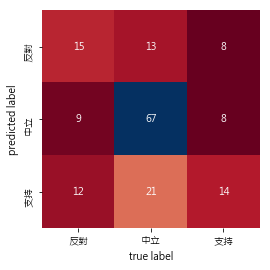

In [58]:
hk_preds = CountVectorizer_MultinomialNB(hk_train, hk_test['內容'])

In [42]:
hk_preds2 = list(hk_preds)
hk_test['立場'] = hk_preds2

In [55]:
hk_test.to_csv("naive_beyes_hk.csv", index = False)

Accuracy score: 0.5596590909090909
Precision score: 0.5596590909090909
Recall score: 0.5596590909090909


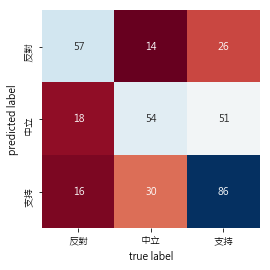

In [59]:
udn_preds = CountVectorizer_MultinomialNB(udn_train, udn_test['內容'])

In [46]:
udn_preds2 = list(udn_preds)
udn_test['立場'] = udn_preds2

In [53]:
udn_test.to_csv("udn_naive_beyes.csv", index = False)

Accuracy score: 0.3541666666666667
Precision score: 0.3541666666666667
Recall score: 0.3541666666666667


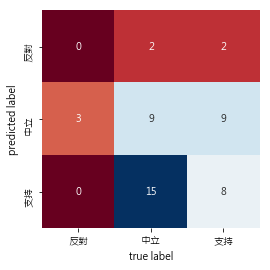

In [60]:
bbc_preds = CountVectorizer_MultinomialNB(bbc_train, bbc_test['內容'])


In [49]:
bbc_preds2 = list(bbc_preds)
bbc_test['立場'] = bbc_preds2

In [54]:
bbc_test.to_csv("bbc_naive_beyes.csv", index = False)

## Tf-idf

In [14]:
from sklearn.feature_extraction.text import  TfidfVectorizer
vectorizer = TfidfVectorizer(binary = False, decode_error = 'ignore')

In [18]:
for i in range(4,12):
    tfidf = vectorizer.fit_transform(hk["jieba_sentence"][(hk['日期'] <= pd.datetime(2019,i,30)) & (hk['日期'] >= pd.datetime(2019,i,1))]).toarray()
    tfidf_name = vectorizer.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf,columns = tfidf_name)
    print(i,'月')
    print(tfidf_df.iloc[0,:][tfidf_df.iloc[0,:]>0].sort_values(ascending = False).head(10))
    print('---------------------------------------------------------')
    

4 月
科技     0.330511
金融     0.308062
陳茂波    0.255508
內地     0.244236
香港     0.225232
市場     0.220341
國際     0.176035
大灣區    0.165256
中心     0.165256
港澳     0.146542
Name: 0, dtype: float64
---------------------------------------------------------
5 月
修例     0.468580
香港     0.219569
邱騰華    0.214286
解釋     0.214286
投資     0.175718
情況     0.142857
美國     0.142857
公眾     0.142857
民主派    0.142857
政府     0.127127
Name: 0, dtype: float64
---------------------------------------------------------
6 月
六四      0.289912
台灣      0.255073
民運      0.225487
六四事件    0.198927
三十年     0.193275
蔡英文     0.175456
政治      0.163240
中國      0.161663
八九      0.161062
民主      0.154366
Name: 0, dtype: float64
---------------------------------------------------------
7 月
顧汝德    0.492435
年輕人    0.158832
政府     0.153755
管治     0.140253
大學     0.139932
社會     0.136338
青年     0.127653
林鄭     0.119872
專訪     0.115983
香港     0.112393
Name: 0, dtype: float64
---------------------------------------------------------
8 月
大陸

In [19]:
for i in range(4,12):
    tfidf = vectorizer.fit_transform(bbc["jieba_sentence"][(bbc['日期'] <= pd.datetime(2019,i,30)) & (bbc['日期'] >= pd.datetime(2019,i,1))]).toarray()
    tfidf_name = vectorizer.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf,columns = tfidf_name)
    print(i,'月')
    print(tfidf_df.iloc[0,:][tfidf_df.iloc[0,:]>0].sort_values(ascending = False).head(10))
    print('---------------------------------------------------------')
    

4 月
中國      0.220794
普京      0.201049
舉行      0.201049
肖揚      0.201049
海上      0.201049
一帶一路    0.201049
論壇      0.168495
朝鮮      0.150787
前院      0.150787
領導人     0.150787
Name: 0, dtype: float64
---------------------------------------------------------
5 月
談判     0.504219
貿易     0.277625
特朗普    0.239414
股市     0.208219
團隊     0.208219
市場     0.191273
中國     0.176748
美國     0.169850
中方     0.149634
關稅     0.138813
Name: 0, dtype: float64
---------------------------------------------------------
6 月
許穎婷    0.399414
香港     0.321650
內地     0.319893
宏基     0.211455
學生     0.203503
同學     0.180371
中國     0.178713
文章     0.176362
認同     0.162334
身份     0.130824
Name: 0, dtype: float64
---------------------------------------------------------
7 月
元朗      0.431086
居民      0.380370
新界      0.236767
香港      0.207381
港英政府    0.136807
丁屋      0.113573
基本法     0.106248
鄉村      0.102605
房屋      0.094823
建制派     0.081249
Name: 0, dtype: float64
------------------------------------------------------

In [20]:
for i in range(4,12):
    tfidf = vectorizer.fit_transform(udn["jieba_sentence"][(udn['日期'] <= pd.datetime(2019,i,30)) & (udn['日期'] >= pd.datetime(2019,i,1))]).toarray()
    tfidf_name = vectorizer.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf,columns = tfidf_name)
    print(i,'月')
    print(tfidf_df.iloc[0,:][tfidf_df.iloc[0,:]>0].sort_values(ascending = False).head(10))
    print('---------------------------------------------------------')
    

4 月
進會      0.259019
台方      0.247249
會和策     0.194264
女友      0.177923
陳同佳     0.172492
協進      0.170352
兩會      0.161817
交流      0.154601
林鄭月娥    0.154536
回信      0.142163
Name: 0, dtype: float64
---------------------------------------------------------
5 月
動議     0.341965
林太     0.216321
信任     0.196075
票反     0.167288
該動議    0.167288
組別     0.167288
贊成票    0.167288
否決     0.153791
上任     0.153791
尹兆堅    0.144214
Name: 0, dtype: float64
---------------------------------------------------------
6 月
韓特        0.333126
英國        0.263669
更顯        0.243283
不移        0.231344
抗爭        0.230016
密切        0.222084
紀念        0.208121
移交        0.192335
中英聯合聲明    0.189364
承諾        0.173815
Name: 0, dtype: float64
---------------------------------------------------------
7 月
巴士     0.548837
調景嶺    0.329851
免費     0.274876
穿梭     0.236253
等候     0.143959
港鐵     0.141420
堵塞     0.139296
乘客     0.130059
人龍     0.123928
大塞車    0.118127
Name: 0, dtype: float64
----------------------------------